In [1]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id
import torchvision.transforms as T
import requests
import io
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from PIL import Image
# Util function for loading point clouds|
import numpy as np
from tqdm import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

from midas_utils import midas
from video_utils import generate_video_from_imgs
from detic_utils import extract_mask_class

def process(depth_map, scale_factor=1, guidance=False):
    depth_map = torch.Tensor(depth_map).squeeze().unsqueeze(0)
    shape = [depth_map.shape[1] // scale_factor, depth_map.shape[2] // scale_factor]
    depth_map = torch.nn.functional.interpolate(depth_map.unsqueeze(1), size=shape, mode="bicubic", align_corners=False)
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = 2.0 * (depth_map - depth_min) / (depth_max - depth_min) - 1.0
    depth_map = torch.cat([depth_map] * 2) if guidance else depth_map
    return depth_map.cpu().squeeze().numpy() # TODO: check

torch.cuda.set_device("cuda:0")

Using cache found in /home/akirchme/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/akirchme/.cache/torch/hub/intel-isl_MiDaS_master
/home/akirchme/.conda/envs/diff2/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Using "coco" vocabulary 
Resetting zs_weight datasets/metadata/coco_clip_a+cname.npy


(667, 1000, 3)


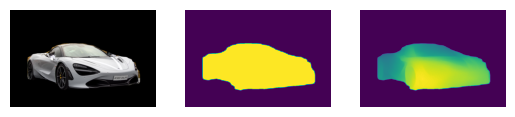

In [9]:
from PIL import Image
import matplotlib.pyplot as plt


'''
Options
'''
do_mask = True
depth_mode = 'center_tau'
precompute_depth = False
show_feature = 'pixel' # ['pixel', 'depth']

'''
Paths
'''
# Set paths
data_path, cls, image_fn = '/home/akirchme/art3d/art3d-multiviewdepthdiffusion/data', 'car', '1'
#data_path, image_fn = '/home/akirchme/data/CUB', '084.Red_legged_Kittiwake/Red_Legged_Kittiwake_0001_795394.jpg'
image_data_path = f'{data_path}/images'
depth_data_path = f'{data_path}/depth'
video_data_path = f'{data_path}/video' if not do_mask else f'{data_path}/video_mask'

'''
Load images
'''
image = np.array(Image.open(f'{image_data_path}/{cls}/{image_fn}.png').convert('RGB'))
print(image.shape)
if do_mask:
    mask_fg = extract_mask_class(image, cls)
    image[~mask_fg] = 0
else:
    mask = image.sum(axis=2) >= 0
if precompute_depth: depth = np.array(Image.open(f'{depth_data_path}/{cls}/{image_fn}.png'))
else: depth = midas(Image.fromarray(image, 'RGB'))

if do_mask:
    depth[~mask_fg] = 0
    
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')
axs[1].imshow(mask_fg)
axs[1].axis('off')
axs[2].imshow(depth)
axs[2].axis('off')
plt.show()

In [1]:
depth_fg = depth[mask_fg]
if depth_mode == 'center_tau':
    mu, tau = depth_fg.mean(), np.abs(depth_fg - depth_fg.mean()).max()
    depth = (depth-mu)/tau
elif depth_mode == 'center_sigma':
    mu, sigma = depth_fg.mean(), depth_fg.std()
    depth = (depth-mu)/sigma
elif depth_mode == 'min_max':
    mini = depth_fg.min()
    maxi = depth_fg.max()
    depth = 2*(depth - mini) / (maxi - mini) - 1
elif depth_mode == 'normal':
    mu, sigma = depth_fg.mean(), depth_fg.std()
    depth = (depth - mu) / sigma

# normalize depth without background
# show depth
# chairs: cubs, 
# visualizations on rigid objects (chairs): generate videos for a few of them

n, m = depth.shape
point_cloud = torch.Tensor([[[2*j/m-1,1-2*i/n,depth[i,j]] for j in range(m)] for i in range(n)])[mask_fg].reshape((-1, 3)).cuda()
pixel_features = torch.Tensor(image[mask_fg]).reshape(-1,3).cuda()/255
depth_features = torch.Tensor(depth)[mask_fg].unsqueeze(-1).repeat((1,3)).cuda()
pixel_point_cloud = Pointclouds(points=[point_cloud], features=[pixel_features])
depth_point_cloud = Pointclouds(points=[point_cloud], features=[depth_features])

point_cloud = pixel_point_cloud if show_feature == 'pixel' else depth_point_cloud

fig = plot_scene({
    "pixel": {
        "object": pixel_point_cloud,
    },
    "depth": {
        "object": depth_point_cloud
    },
    
}, axis_args=AxisArgs(backgroundcolor="rgb(0,0,0)"), pointcloud_marker_size=0.5, ncols=2) # kwarg axis_args
fig.show()

NameError: name 'depth' is not defined

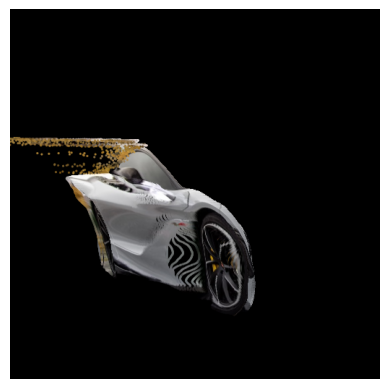

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 310.06it/s]


In [12]:
resolution = 512
def render_pose(elev = 0, azim = 0):
    R, T = look_at_view_transform(dist=2, elev=elev, azim=azim)
    #cameras = FoVPerspectiveCameras(device='cuda', R=R, T=T, znear=0.01)
    cameras = FoVOrthographicCameras(device='cuda', R=R, T=T, znear=0.01)
    raster_settings = PointsRasterizationSettings(
        image_size=resolution, 
        radius = 0.008,
        points_per_pixel = 10,
        bin_size = None
    )

    # Create a points renderer by compositing points using an weighted compositor (3D points are
    # weighted according to their distance to a pixel and accumulated using a weighted sum)
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
        compositor=AlphaCompositor()#NormWeightedCompositor()
    )

    images = renderer(pixel_point_cloud)
    output = images[0, ..., :3].cpu().numpy()
    return output


plt.axis("off");
plt.imshow(render_pose(0, -75))
plt.show()

N = 600
ampl = 60 # 75
img_spiral = [render_pose(elev=ampl*0.4*np.sin(2*np.pi*n/N+np.pi), azim=ampl*np.cos(2*np.pi*n/N+np.pi)) for n in tqdm(range(N), position=0, leave=True)]
# create OpenCV video writer
generate_video_from_imgs(f'{video_data_path}/{cls}/{image_fn}.mp4', img_spiral, size=(resolution, resolution), fps=30)